## Notebook to research diabetes onset 


e) Matched Controls Diabetes Onset Curve(Blue 3)

   1. Get all the canary patients who have their CC_DIABETES flag equals 0
   on their registered date.
   
       1. Pick a matching algorithm
   2. Create the macthed population
       2. For each canary patient let their registration month be i
       2. Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       2. Set the index date for these pmpm controls patients to be month i.
       2. This forms a matched set of roughly 30 times the number of canary patients and each control has an index date.
   
   3. Compute Onset of Diabetes for month i: 
       3. Get all the matched controls with index date prior to month i.
       3. For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from e.3 that had
        the flag CC_DIABETES = 1 at Month (i) and CC_DIABETES = 0 at Month (i-1) (Note these patients must be in pmpm on both months).
       3. S is the total number of matched controls included in the pmpm both in month i and month i-1 
       3. For Month i we define the diabetes onset rate(DOR) as:
             DOR =  DO/S*1000

       3. Suggestion: Remove from  S the subjects that  have the flag CC_DIABETES = 1 at month i-1

   

In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext Cython
%reload_ext Cython

In [12]:
#built-in
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import sys

path = str(Path.home()) + '/rpi-canary-eval/temp'
git_path = str(Path.home()) + '/rpi-canary-eval'
sys.path.append(git_path + '/modules')


#custom
import data_process
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from path import path_dict, col_seq_cc, col_seq_elx, col_seq_cc_all

#options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

In [3]:
#!aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/nneehal/MODELS/TF_Full_Model_m2 'TF_Latent_Model_m2'

### Load Pmpm Canary data

In [10]:
%%time
canary_p = '../../data/CANARY/'
pmpm_p = '../../temp/CC_PMPM.p'

canary = pq.read_table(canary_p).to_pandas()
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.47 s, sys: 6.83 s, total: 12.3 s
Wall time: 12.2 s


In [11]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  CC_PERIPHERAL  \
0  2567954  201709        F               95       1485      0.0           0.0                0.0     0.0        1.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0              1.0            0.0   
1  2567954  201802        F               95          2      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          2                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0              1.0            0.0   
2  2567954  201711        F               95          2      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          2                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0              1.0            0.0   
3  2567954  201804 

### Choose Onset Column Name

In [26]:
onset = "CC_DIABETES"

### Process PMPM - rearrange columns and produce ELX Score column

In [13]:
pmpm = pmpm[col_seq_cc_all]

In [7]:
# #extra - when elx
# vw_weights = np.array([7, 5, -1, 4, 2, 0, 0, 7, 6, 3, 0, 0, 0, 5, 11, 0, 9, 12, 4, 0, 3, -4, 6, 5, -2, -2, 0, -7, 0, -3])
# pmpm["ELX_SCORE"] = np.dot(pmpm.loc[:,"ELX_GRP_1":"ELX_GRP_31"].values, vw_weights)

## Log the cost at source - PMPM

In [14]:
%%time
pmpm.ALLOW_AMT = pmpm.ALLOW_AMT.apply(data_process.log_)

# #-- extra
# pmpm.ALLOW_IP = pmpm.ALLOW_IP.apply(data_process.log_)
# pmpm.ALLOW_ER = pmpm.ALLOW_ER.apply(data_process.log_)

CPU times: user 12.8 s, sys: 395 ms, total: 13.2 s
Wall time: 13.2 s


### Process Canary, 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated

In [15]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max()) #from diabetes_onset file
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 8.2 s, sys: 4.7 s, total: 12.9 s
Wall time: 12.9 s


### Keep Canary Patients from their date of registeration and onwards which did not have CC_DIABETES flag on, on their date of registration

In [16]:
%%time
treated2 = in_canary(treated.copy(), canary2)
treated2 = filter_first_month_diabetes(treated2.copy(), onset=onset)
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 7.21 s, sys: 90.4 ms, total: 7.3 s
Wall time: 7.29 s


### Hierarchical Clustering

In [17]:
%%time

#model 3
# columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR', 'ELX_GRP_1', 'ELX_GRP_2', 'ELX_GRP_3', 'ELX_GRP_4', 'ELX_GRP_5','ELX_GRP_6','ELX_GRP_7','ELX_GRP_8','ELX_GRP_9',
#            'ELX_GRP_10','ELX_GRP_11','ELX_GRP_12','ELX_GRP_13','ELX_GRP_14','ELX_GRP_15','ELX_GRP_16','ELX_GRP_18', 'ELX_GRP_19','ELX_GRP_20','ELX_GRP_21','ELX_GRP_22','ELX_GRP_23','ELX_GRP_24',
#            'ELX_GRP_25','ELX_GRP_26','ELX_GRP_27','ELX_GRP_28','ELX_GRP_29','ELX_GRP_30','ELX_GRP_31']

#model 4
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR', 'CC_CHRONIC_KIDNEY', 'CC_HEART_FAILURE', 'CC_ISCHEMIC', 'CC_STROKE', 'CC_HYPERLIPIDEMIA', 'CC_HYPERTENSION', 'CC_DX_CNT']

treated0, treated1, model, link_matr,  clustermapdat = agglomerative(treated2.copy(), columns_to_match, to_log=None)

CPU times: user 735 ms, sys: 0 ns, total: 735 ms
Wall time: 735 ms


### Plot Cluster Map

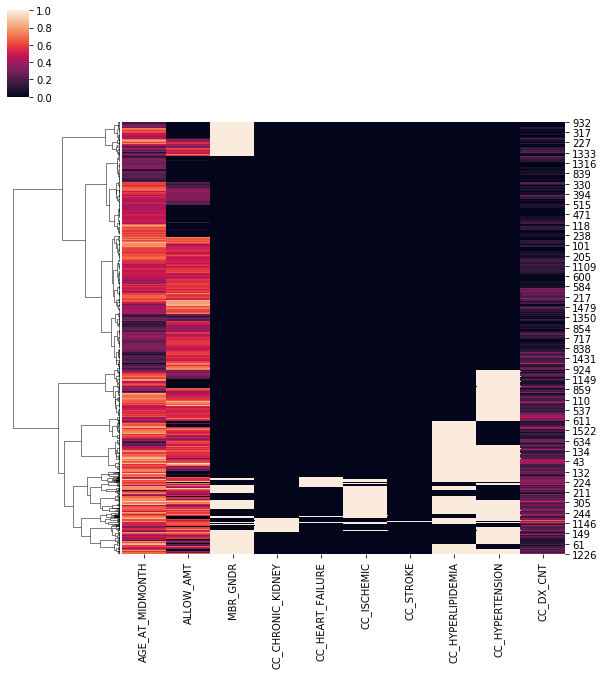

In [18]:
sns.clustermap(clustermapdat, method = 'ward', standard_scale=1, row_linkage = link_matr, col_cluster = False)

### Transform with NN

In [20]:
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')

model = models.load_model(path+"/TF_Latent_Model_m4", compile=False)

In [27]:
cols_to_keep = ["PERS_ID", "MYR", onset]

In [28]:
treated0.head()

PERS_ID     MYR  AGE_AT_MIDMONTH  MBR_GNDR  ALLOW_AMT  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  CC_PERIPHERAL  \
0  2738758  202103               66         0   5.455321      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          4                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             1.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         1.0              0.0            0.0   
1  2738758  201908               65         0   0.000000      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0              0.0            0.0   
2  2738758  202010               66         0   6.224558      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             1.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0              0.0            0.0   
3  2738758  201

In [24]:
%%time
#transform data of sick and healthy treated, and controls
tr0 = data_process.transform_features_with_NN(model, treated0.copy(), cols_to_keep)
tr1 = data_process.transform_features_with_NN(model, treated1.copy(), cols_to_keep)
tr2 = data_process.transform_features_with_NN(model, treated2.copy(), cols_to_keep)
cntrls = data_process.transform_features_with_NN(model, controls.copy(), cols_to_keep)

CPU times: user 4min 59s, sys: 1min 16s, total: 6min 15s
Wall time: 2min 21s


### For each patient in the treated group in its registartion month find a population of matched controls in the same month by using 

In [29]:
%%time

latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']

propensity_func_args = {'match_on':latent_cols, 'neighbors_per_treated': 20, 'onset':onset}
matched0, matched_data0 = matched_population(tr0.copy(), 
                                           cntrls.copy(),
                                           propensity_func, 
                                           propensity_func_args)

matched1, matched_data1 = matched_population(tr1.copy(), 
                                           cntrls.copy(),
                                           propensity_func, 
                                           propensity_func_args)

Mathcing Function: propensity_func


Propensity Score Matching...fitting model
Creating Matched Set...


685it [10:59,  1.04it/s]


Mathcing Function: propensity_func


Propensity Score Matching...fitting model
Creating Matched Set...


896it [14:32,  1.03it/s]


CPU times: user 28min 49s, sys: 7min 19s, total: 36min 9s
Wall time: 28min 12s


In [32]:
random_matching_func_args = {'neighbors_per_treated': 100, "onset":onset}
random_controls = matched_population(tr2.copy(), 
                                       cntrls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


In [30]:
#%pwd
%cd temp/
!mkdir ldata
!mkdir odata
%cd ..

[Errno 2] No such file or directory: 'temp/'
/mnt/home/nneehal/rpi-canary-eval/notebooks/experiments
/mnt/home/nneehal/rpi-canary-eval/notebooks


In [33]:
matched_data0.to_pickle(path+'/ldata/match0_l.p')
matched_data1.to_pickle(path+'/ldata/match1_l.p')
random_controls.to_pickle(path+'/ldata/random_l.p')
tr0.to_pickle(path+'/ldata/treated0_l.p')
tr1.to_pickle(path+'/ldata/treated1_l.p')

## Transform Back to Original Space - match0, match1, random_controls
matched0 (latent) -> transform using controls -> matched0_orig <br/> 
matched1 (latent) -> transform using controls -> matched1_orig <br/>
random_controls (latent) -> transform using controls -> random_controls_orig <br/>
treated0(original) -> done -> tr0 (latent) <br/>
treated1(original) -> done -> tr1 (latent) <br/>

In [34]:
matched_data0 = controls[controls.set_index(["PERS_ID", "MYR"]).index.isin(matched_data0.set_index(["PERS_ID", "MYR"]).index)].sort_values(by=["PERS_ID", "MYR"])
matched_data1 = controls[controls.set_index(["PERS_ID", "MYR"]).index.isin(matched_data1.set_index(["PERS_ID", "MYR"]).index)].sort_values(by=["PERS_ID", "MYR"])
random_controls = controls[controls.set_index(["PERS_ID", "MYR"]).index.isin(random_controls.set_index(["PERS_ID", "MYR"]).index)].sort_values(by=["PERS_ID", "MYR"])

In [35]:
matched_data0.to_pickle(path+'/odata/match0_o.p')
matched_data1.to_pickle(path+'/odata/match1_o.p')
random_controls.to_pickle(path+'/odata/random_o.p')
treated0.to_pickle(path+'/odata/treated0_o.p')
treated1.to_pickle(path+'/odata/treated1_o.p')

### Run the Diabetes onset Function (changed Diabetes_TR -> Diabetes_Tr0 and Diabetes_Tr1)

In [36]:
%%time
con_onset0 = diabet_onset(matched_data0.copy(), 'Diabetes_Con0', onset=onset)
con_onset1 = diabet_onset(matched_data1.copy(), 'Diabetes_Con1', onset=onset)

treated_onset0 = diabet_onset(treated0.copy(), 'Diabetes_Tr', onset=onset)
treated_onset1 = diabet_onset(treated1.copy(), 'Diabetes_Tr', onset=onset)

pmpm2 = filter_first_month_diabetes(pmpm.copy(), onset=onset)
pmpm_onset = diabet_onset(pmpm2, 'Diabetes_PM', onset=onset)

CPU times: user 5min 20s, sys: 19.1 s, total: 5min 39s
Wall time: 5min 37s


In [37]:
random_onset = diabet_onset(random_controls.copy(), 'Diabetes_Rnd', onset=onset)

In [38]:
con_onset20 = con_onset0.rename(columns = {'Sample': 'Sample_Con0', 'Per_1000':'Per_1000_Con0'})
con_onset21 = con_onset1.rename(columns = {'Sample': 'Sample_Con1', 'Per_1000':'Per_1000_Con1'})

treated_onset20 = treated_onset0.rename(columns = {'Sample': 'Sample_Tr0', 'Per_1000':'Per_1000_Tr0'})
treated_onset21 = treated_onset1.rename(columns = {'Sample': 'Sample_Tr1', 'Per_1000':'Per_1000_Tr1'})

pmpm_onset2 = pmpm_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})

In [39]:
random_onset2 = random_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})
joint = pd.concat((con_onset20, con_onset21, treated_onset20, treated_onset21,  pmpm_onset2, random_onset2), axis = 1)

### Diabetes Onset Per Month

1. **_Con : For Matched Controls Population**
2.  **_Tr : For Canary Treated Population**
3. **_PM : For the whole PMPM Population**
4. **_Rnd: For a Random Matching**

In [40]:
joint.describe().loc[['mean', 'std']]

Sample_Con0  Diabetes_Con0  Per_1000_Con0  Sample_Con1  Diabetes_Con1  Per_1000_Con1  Sample_Tr0  Diabetes_Tr  Per_1000_Tr0  Sample_Tr1  Diabetes_Tr  Per_1000_Tr1      Sample_PM  Diabetes_PM  Per_1000_PM     Sample_PM  Diabetes_Rnd  Per_1000_PM
mean  3689.333333      10.309524       4.099265  4980.684211       8.105263       1.445622  204.333333     0.571429      1.425622  304.447368     0.473684      1.661267  143003.882353   279.901961     1.961085  32716.238095     58.119048     1.707632
std   3460.448502       9.503499       8.028650  4100.933606       7.675125       1.173393  196.438492     0.914460      2.217298  259.822153     0.761820      4.361900   13718.389511    44.775554     0.272818  28509.780063     50.661576     0.743446

In [41]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

In [42]:
joint2 = pd.concat((con_onset0, con_onset1, treated_onset0, treated_onset1,  pmpm_onset, random_onset), axis = 1)
jointcon0 = joint2.Per_1000.iloc[1:, 0].reset_index()
jointcon1 = joint2.Per_1000.iloc[1:, 1].reset_index()
jointTr0 = joint2.Per_1000.iloc[1:, 2].reset_index()

jointTr1 = joint2.Per_1000.iloc[1:, 3].reset_index()
jointpmpm = joint2.Per_1000.iloc[1:, 4].reset_index()
jointrandom = joint2.Per_1000.iloc[1:, 5].reset_index()


**Plot Top Left**: $f(x)$ = Onset Per 1000 per month </br>
**Plot Top Right and Bottom Left**: $F(x) = \int_0^x f(y)dy$ Cumulative sum of the rates

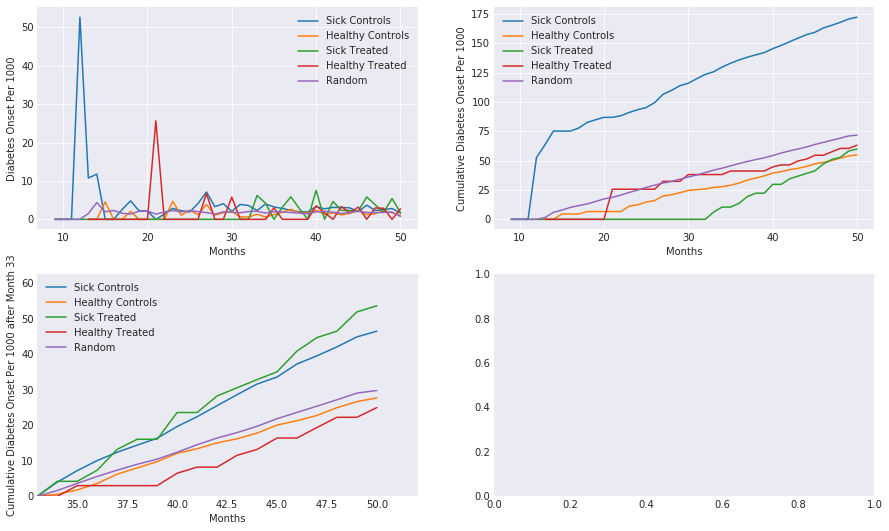

In [43]:
from diabetes_onset_plotter import plot_onset, plot_onset2
names = ['Sick Controls', 'Healthy Controls', 'Sick Treated', 'Healthy Treated', 'Random']
f, ax = plot_onset2(jointcon0, jointcon1, jointTr0, jointTr1, jointrandom, names = names)
plt.show()

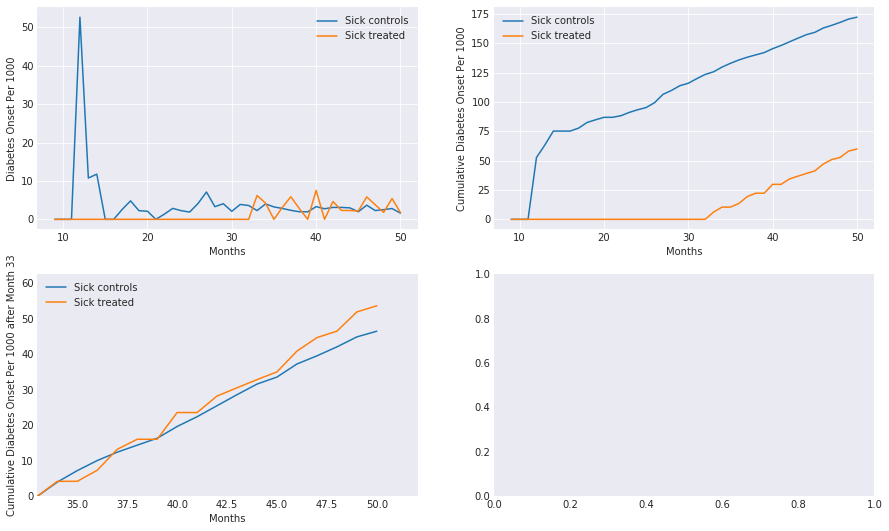

In [44]:
names = [ 'Sick controls',  'Sick treated']

f, ax = plot_onset2(jointcon0, jointTr0, names = names)

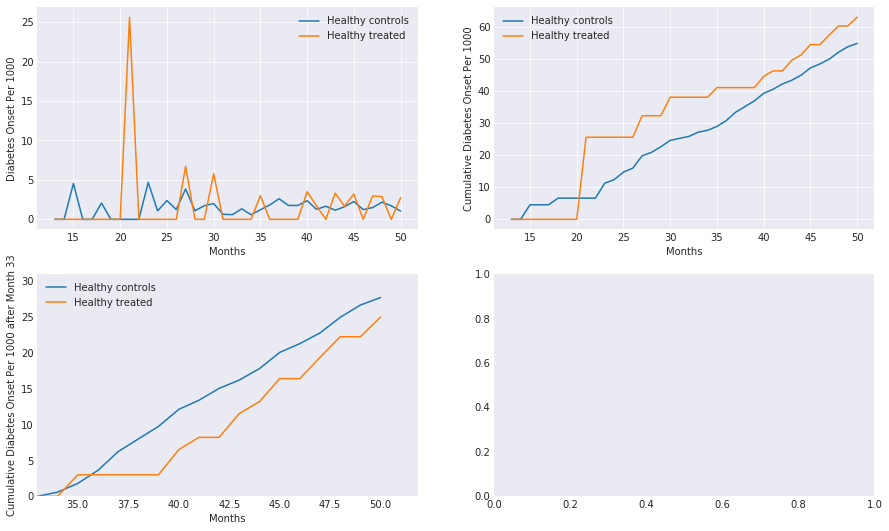

In [45]:
names = [ 'Healthy controls',  'Healthy treated']

f, ax = plot_onset2(jointcon1, jointTr1, names = names)


In [46]:
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

# columns_to_match = ['ELX_GRP_1', 'ELX_GRP_2', 'ELX_GRP_3', 'ELX_GRP_4', 'ELX_GRP_5','ELX_GRP_6','ELX_GRP_7','ELX_GRP_8','ELX_GRP_9',
#            'ELX_GRP_10','ELX_GRP_11','ELX_GRP_12','ELX_GRP_13','ELX_GRP_14','ELX_GRP_15','ELX_GRP_16','ELX_GRP_18', 'ELX_GRP_19','ELX_GRP_20','ELX_GRP_21','ELX_GRP_22','ELX_GRP_23','ELX_GRP_24',
#            'ELX_GRP_25','ELX_GRP_26','ELX_GRP_27','ELX_GRP_28','ELX_GRP_29','ELX_GRP_30','ELX_GRP_31']


#model 4
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR', 'CC_CHRONIC_KIDNEY', 'CC_HEART_FAILURE', 'CC_ISCHEMIC', 'CC_STROKE', 'CC_HYPERLIPIDEMIA', 'CC_HYPERTENSION', 'CC_DX_CNT']


#orig-->
#columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
#                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']

tr_desc0 = treated0[columns_to_match].describe().loc[['mean', 'std']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc0 = tr_desc0.T

tr_desc1 = treated1[columns_to_match].describe().loc[['mean', 'std']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc1 = tr_desc1.T

con_desc0 = matched_data0[columns_to_match].describe().loc[['mean', 'std']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

con_desc1 = matched_data1[columns_to_match].describe().loc[['mean', 'std']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc1 = con_desc1.T

pmpm_desc = pmpm2[columns_to_match].describe().loc[['mean', 'std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc = random_controls[columns_to_match].describe().loc[['mean', 'std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

alli = pd.concat((tr_desc0, tr_desc1, con_desc0, con_desc1, pmpm_desc, random_desc), axis = 1, keys = ['Sick Treated','Healthy Treated',
                                                                                                       'Sick Controls', 'Healthy Controls',
                                                                                                       'Genaral Population', 'Random'] )

In [47]:
alli

Sick Treated            Healthy Treated            Sick Controls            Healthy Controls            Genaral Population                Random           
                          mean        std            mean        std          mean        std             mean        std               mean        std       mean        std
AGE_AT_MIDMONTH      56.354006  10.973167       46.045574  11.638999     63.688880  12.906672        49.186179  12.962740          48.759167  19.438676  49.817319  19.376115
ALLOW_AMT             4.648627   2.624379        3.721683   2.830985      4.477589   2.713960         3.567231   2.861207           3.812455   2.889771   3.771346   2.890092
MBR_GNDR              0.264781   0.441240        0.126524   0.332452      0.428351   0.494841         0.267136   0.442465           0.421103   0.493736   0.419748   0.493518
CC_CHRONIC_KIDNEY     0.072836   0.259882        0.005657   0.075002      0.092542   0.289790         0.011317   0.105777           0.055803   0.229541   0.057735   0.233243
CC_HEART_FAILURE      0.052806   0.223659        0.002709   0.051979      0.045358   0.208090         0.003884   0.062201           0.033958   0.181120   0.038175   0.191618
CC_ISCHEMIC           0.181555   0.385498        0.003028   0.054943      0.208781   0.406439         0.016499   0.127384           0.102430   0.303213   0.114753   0.318723
CC_STROKE             0.015210   0.122394        0.001275   0.035683      0.021336   0.144501         0.002208   0.046936           0.010214   0.100547   0.011105   0.104793
CC_HYPERLIPIDEMIA     0.486397   0.499842        0.066688   0.249491      0.479402   0.499577         0.096660   0.295495           0.238015   0.425868   0.248040   0.431875
CC_HYPERTENSION       0.656491   0.474905        0.068441   0.252511      0.649675   0.477073         0.084936   0.278787           0.283097   0.450503   0.293366   0.455305
CC_DX_CNT             3.869644   2.246758        2.023185   1.758854      3.975971   2.582152         1.884724   1.868694           2.539357   2.552348   2.716505   2.584410

### Distribution Plots For Treated and Matched Controls

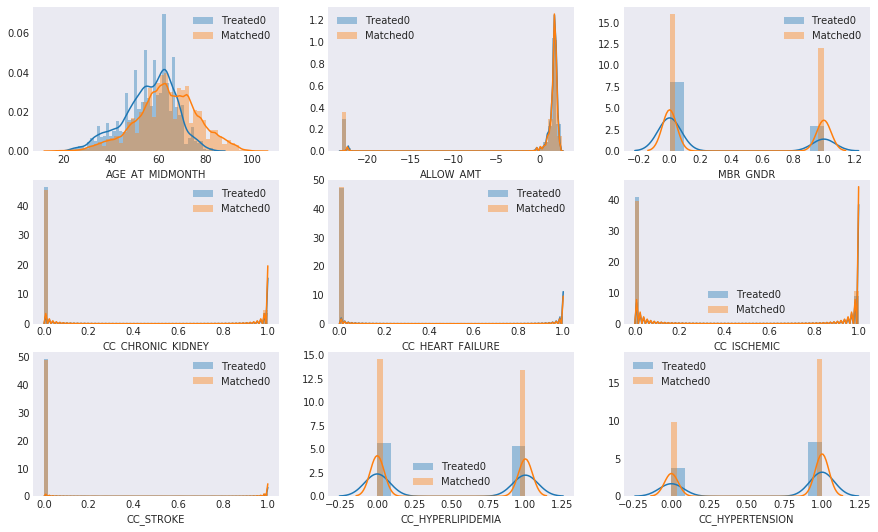

In [48]:
fig, ax = plt.subplots(3,3, figsize = (15,9))
for i in range(3):
    for j in range(3):
        column = columns_to_match[i*3 + j]
        if column == 'ALLOW_AMT':
            treated00 = treated0.copy()
            treated00[column] = np.log(treated00[column].values + 10**(-10))
            matched00 = matched_data0.copy()
            matched00[column] = np.log(matched00[column].values + 10**(-10))

            sns.distplot(treated00[column], ax = ax[i,j])
            sns.distplot(matched00[column], ax = ax[i,j])
            ax[i,j].legend(['Treated0', 'Matched0'])
        else:
            sns.distplot(treated0[column], ax = ax[i,j])
            sns.distplot(matched_data0[column], ax = ax[i, j])
            ax[i,j].legend(['Treated0', 'Matched0'])

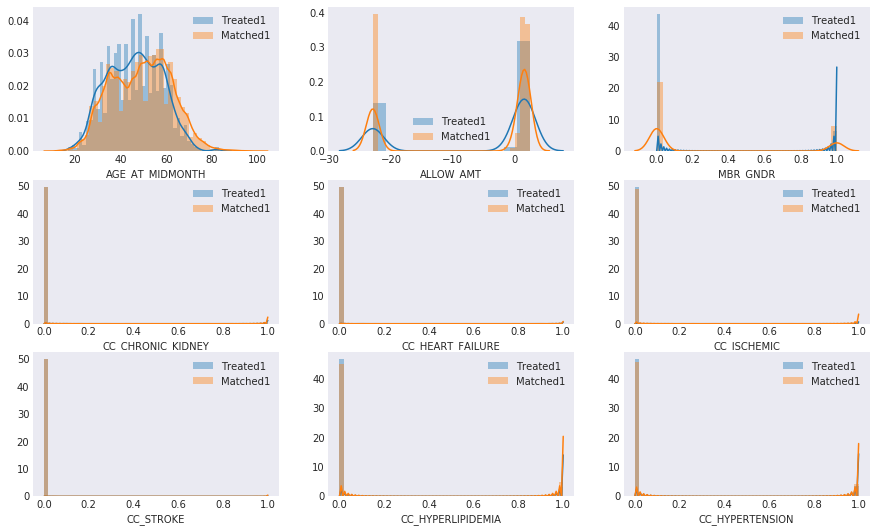

In [49]:
fig, ax = plt.subplots(3,3, figsize = (15,9))
for i in range(3):
    for j in range(3):
        column = columns_to_match[i*3 + j]
        
        try:
            if column == 'ALLOW_AMT':
                treated00 = treated1.copy()
                treated00[column] = np.log(treated00[column].values + 10**(-10))
                matched00 = matched_data1.copy()
                matched00[column] = np.log(matched00[column].values + 10**(-10))

                sns.distplot(treated00[column], ax = ax[i,j])
                sns.distplot(matched00[column], ax = ax[i,j])
                ax[i,j].legend(['Treated1', 'Matched1'])
            else:
                sns.distplot(treated1[column], ax = ax[i,j])
                sns.distplot(matched_data1[column], ax = ax[i, j])
                ax[i,j].legend(['Treated1', 'Matched1'])
        except:
            continue

## Distribution of latent space

In [50]:
import pickle
with open(path+'/ldata/match0_l.p', 'rb') as fp:
    controls_sick_latent = pickle.load(fp)
with open(path+'/ldata/match1_l.p', 'rb') as fp:
    controls_healthy_latent = pickle.load(fp)
with open(path+'/ldata/random_l.p', 'rb') as fp:
    random_latent = pickle.load(fp)
with open(path+'/ldata/treated0_l.p', 'rb') as fp:
    treated_sick_latent = pickle.load(fp)
with open(path+'/ldata/treated1_l.p', 'rb') as fp:
    treated_healthy_latent = pickle.load(fp)

In [51]:
columns_to_match = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']

tr_desc0 = treated_sick_latent[columns_to_match].describe().loc[['mean','std']].T
tr_desc1 = treated_healthy_latent[columns_to_match].describe().loc[['mean','std']].T
con_desc0 = controls_sick_latent[columns_to_match].describe().loc[['mean','std']].T
con_desc1 = controls_healthy_latent[columns_to_match].describe().loc[['mean','std']].T
random_desc = random_latent[columns_to_match].describe().loc[['mean','std']].T

alli_latent = pd.concat((tr_desc0, tr_desc1, con_desc0, con_desc1, random_desc), axis = 1, keys = ['Sick Treated', 'Healthy Treated', 'Sick Controls', 'Healthy Controls', 'Random'] )

In [52]:
alli_latent

Sick Treated           Healthy Treated           Sick Controls           Healthy Controls              Random          
           mean       std            mean       std          mean       std             mean       std      mean       std
x1    -0.570447  0.808206        0.018120  0.510273     -0.500876  0.787766        -0.013751  0.525867 -0.060780  0.709231
x2    -1.631342  0.817911       -2.744811  0.778719     -1.465690  0.896426        -2.628703  0.811497 -2.516880  1.478816
x3     1.031711  0.832024        2.078362  0.578578      0.970275  0.769657         2.012837  0.614744  1.846956  1.080526
x4     1.395928  0.988341        2.976701  0.927252      1.316599  1.051593         2.846881  0.975222  2.598060  1.568039
x5    -0.120275  0.771452       -0.405660  0.510990     -0.149795  0.772827        -0.354388  0.538538 -0.553083  0.807966
x6    -0.064821  1.173593       -1.752880  0.854675      0.119468  1.244534        -1.609842  0.929422 -1.322968  1.889980
x7    -0.653940  0.726440       -0.356385  0.290822     -0.599619  0.704777        -0.372967  0.368044 -0.410269  0.593719
x8    -1.427496  0.706136       -0.904629  0.335011     -1.361505  0.664953        -0.926414  0.360780 -1.043177  0.546695

## Save matched data in S3

In [53]:
import os
l_files_list = os.listdir(git_path+"/temp/ldata/")
o_files_list = os.listdir(git_path+"/temp/odata/")

In [54]:
#save in S3
import boto3
s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'
for file in l_files_list:
    s3.upload_file( git_path+"/temp/ldata/"+file,
                    bucket, 
                    'rpi/nneehal/DATA/ldata/metabolic/'+file,
                    ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})
for file in o_files_list:
    s3.upload_file( git_path+"/temp/odata/"+file,
                    bucket, 
                    'rpi/nneehal/DATA/odata/metabolic/'+file,
                    ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})

### Pairplots - Depricated Block

In [55]:
# #import matched controls for sick and healthy treated in latent space
# md0 = pd.read_pickle(git_path+"/temp/ldata/match0_l.p").sort_values(by=["PERS_ID","MYR"])
# md1 = pd.read_pickle(git_path+"/temp/ldata/match1_l.p").sort_values(by=["PERS_ID","MYR"])

In [56]:
# columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
#                    'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']

In [57]:
# %%time
# #x1-x8 VS original 9 columns for SICK CONTROLS
# sns.pairplot(pd.concat([md0[latent_cols].reset_index(drop=True), matched_data0[columns_to_match].reset_index(drop=True)], axis=1),
#             x_vars=columns_to_match,
#             y_vars=latent_cols)

In [58]:
# %%time
# #x1-x8 VS original 9 columns for SICK TREATED
# sns.pairplot(pd.concat([tr0[latent_cols].reset_index(drop=True), treated0[columns_to_match].reset_index(drop=True)], axis=1),
#             x_vars=columns_to_match,
#             y_vars=latent_cols)

In [59]:
# %%time
# #x1-x8 VS original 9 columns for HEALTHY CONTROLS
# sns.pairplot(pd.concat([md1[latent_cols].reset_index(drop=True), matched_data1[columns_to_match].reset_index(drop=True)], axis=1),
#             x_vars=columns_to_match,
#             y_vars=latent_cols)

In [60]:
# %%time
# #x1-x8 VS original 9 columns for HEALTHY TREATED
# sns.pairplot(pd.concat([tr1[latent_cols].reset_index(drop=True), treated1[columns_to_match].reset_index(drop=True)], axis=1),
#             x_vars=columns_to_match,
#             y_vars=latent_cols)